## Imports

In [3]:
import pandas as pd
import numpy as np 
from math import exp
import seaborn as sns
import matplotlib.pyplot as plt
import json
from scipy.stats import iqr
from random import uniform as u
%matplotlib inline
sns.set()

# Get data

In [3]:
cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recov = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')


In [ ]:
plt.plo

## Set ```N```,```dt``` ,```alfa```, ```gamma``` and ```days_historic``` , and calculate ```s_data``` 

In [2]:
N = 2e8 #Initial population
i_data = np.array(cases[cases['Country/Region']=='Brazil'].iloc[0,4:])
outbreak = np.where(i_data==1)[0][0]
i_data = i_data[outbreak:] #infected daily
#d_data = np.array(deaths[deaths['Country/Region']=='Brazil'].iloc[0,4:])
#d_data = d_data[outbreak:] #deaths daily
r_data = np.array(recov[recov['Country/Region']=='Brazil'].iloc[0,4:])
r_data = r_data[outbreak:] #recovered daily
days_historic = [i for i in range(len(i_data))]

#N = S+I+R+D
s_data = np.array([N-(i_data[i]+r_data[i]) for i in range(len(i_data))])
alfa = 0.03
gamma = 0.01

NameError: name 'np' is not defined

## Plot historic data

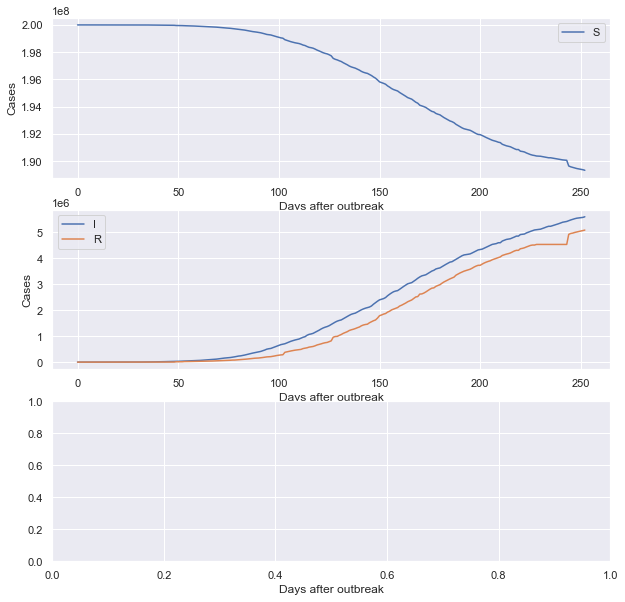

In [82]:
fig,axs = plt.subplots(3)
fig.set_size_inches(10, 10, forward=True)
axs[0].plot(s_data,label='S')
axs[1].plot(i_data,label='I')
axs[1].plot(r_data,label='R')
#axs[2].plot(d_data,label='D')
axs[0].set_xlabel('Days after outbreak')
axs[1].set_xlabel('Days after outbreak')
axs[2].set_xlabel('Days after outbreak')
axs[0].set_ylabel('Cases')
axs[1].set_ylabel('Cases')
#axs[2].set_ylabel('Cases')
axs[0].legend()
axs[1].legend()
#axs[2].legend();

## Calculate ```beta_data```, ```ro_data``` and ```R0_data```

0.003137773311014689


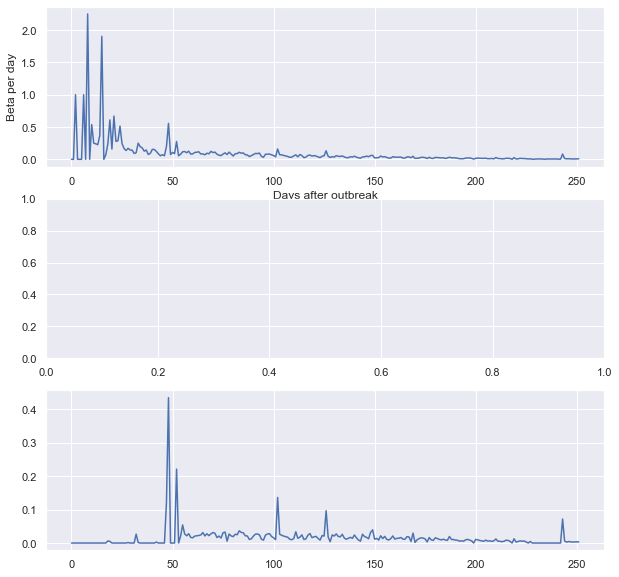

In [83]:
#s'(t) = -beta*s(t)*i(t)*dt/N => beta = -s'(t)*N/(s(t)*i(t)) =>
beta_data = np.array([(s_data[i]-s_data[i+1])*N/(s_data[i]*i_data[i]) for i in range(len(s_data)-1)])
beta_data[np.isnan(beta_data)] = 0.0
beta_data = beta_data.round(4)

#d'(t) = ro*alfa*i(t) => ro = d'(t)/[i(t)*alfa]

#ro_data = np.array([(d_data[i+1]-d_data[i])/(i_data[i]*alfa) for i in range(len(d_data)-1)])
#ro_data = ro_data.round(4)

#r'(t) = gamma*i(t)

gamma_data = np.array([(r_data[i+1]-r_data[i])/i_data[i] for i in range(len(r_data)-1)])


fig,axs = plt.subplots(3)
fig.set_size_inches(10,10, forward=True)
axs[0].plot(beta_data)
#axs[1].plot(ro_data)
axs[2].plot(gamma_data)
axs[0].set_xlabel('Days after outbreak')
#axs[1].set_xlabel('Days after outbreak')
axs[0].set_ylabel('Beta per day')
#axs[1].set_ylabel('Ro per day');
print(gamma_data[-1])

## Remove outliers

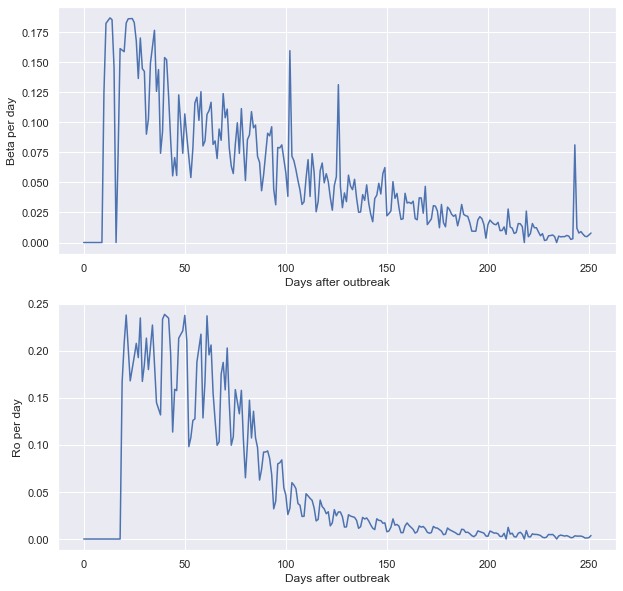

In [84]:
p_25, p_75 = np.percentile(beta_data, [25, 75])
iqr = p_75 - p_25

upper_bound_beta = p_75 + 1.5 * iqr
lower_bound_beta = p_75 + 1.5 * iqr 

p_25, p_75 = np.percentile(ro_data, [25, 75])
iqr = p_75 - p_25

upper_bound_ro = p_75 + 1.5 * iqr
lower_bound_ro = p_25 - 1.5 * iqr

def remove_outliers(lower,upper,data):
    
    def have_outliers(data):
        for x in data:
            if x < lower or x > upper:
                return True
        return False
    while have_outliers(data):
        for i in range(len(data)-1):
            if data[i] < lower or data[i]> upper:
                data[i] = (data[i-1]+data[i+1])/2
            else:
                pass
        

    return data
beta_data = remove_outliers(0.0,upper_bound_beta,beta_data)
ro_data = remove_outliers(0.0,upper_bound_ro,ro_data)
fig,axs = plt.subplots(2)
fig.set_size_inches(10,10, forward=True)
axs[0].plot(beta_data)
axs[1].plot(ro_data)
axs[0].set_xlabel('Days after outbreak')
axs[1].set_xlabel('Days after outbreak')
axs[0].set_ylabel('Beta per day')
axs[1].set_ylabel('Ro per day');

# Fitting the curve for ```beta_data``` and ```ro_data```

### Removing initial zeroish elements (this is just for fitting)

In [85]:
for i in range(len(beta_data)):
    if round(beta_data[i],2) != .00:
        fit_beta = i
        break
        
for i in range(len(ro_data)):
    if round(ro_data[i],2) != .00:
        fit_ro = i
        break
        
beta_data_fit = beta_data[fit_beta:]
ro_data_fit = ro_data[fit_ro:]

### Functions used to fit

In [86]:

def y(A, b, x):
    return A*exp(b*x) 

def fit(data,A,b):
    tol = 1e-9
    p = 0.0001
    N = 50
    # Achar a derivada parcial em relação a A e a b pra cada xi, yi dentro de L
    def gradiente(A, b, data):
        derA = 0
        derB = 0
        for xi, yi in data:
            derA += 2*(y(A, b, xi)-yi)*exp(b*xi)
            derB += 2*(y(A, b, xi)-yi)*A*(-xi)*exp(b*xi)
        derA/=len(data)
        derB/=len(data)

        return derA, derB

    count = 0
    derA, derB = gradiente(A, b, data)
    while count < N and abs(derA) > tol and abs(derB) > tol:
        A -= derA*p
        b -= derB*p
        derA, derB = gradiente(A, b, data)
        count += 1
    return A,b


A0_beta= 0.2
b0_beta= -.01
A0_ro = .5
b0_ro = -0.02

#correct the days starting at the first non-zeroish value

days_beta_fit = [i+fit_beta for i in range(len(beta_data_fit))]
days_ro_fit = [i+fit_ro for i in range(len(ro_data_fit))]

A_beta,b_beta = fit(list(zip(days_beta_fit,beta_data_fit)),A0_beta,b0_beta)
A_ro, b_ro = fit(list(zip(days_ro_fit,ro_data_fit)),A0_ro,b0_ro)

print(A_beta,b_beta)
print(A_ro,b_ro)

0.19994916282763442 -0.009188589371885486
0.49994793107539925 -0.019165646802982675


## Comparing data and fitted curve

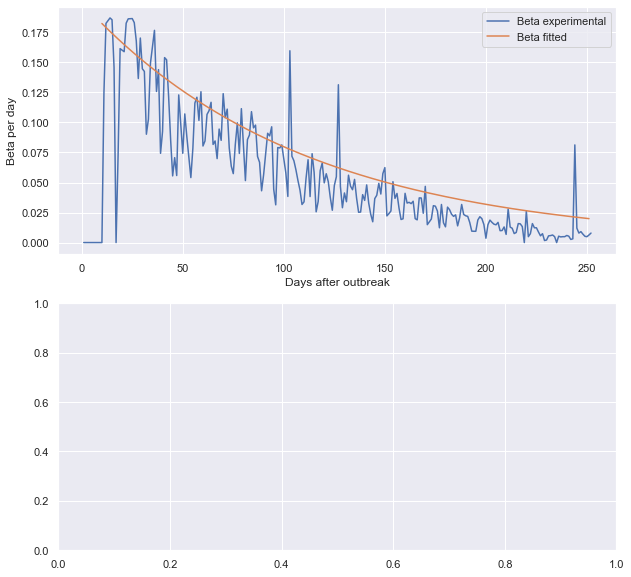

In [95]:
beta_curve = [y(A_beta,b_beta,day) for day in days_beta_fit]
ro_curve = [y(A_ro,b_ro,day) for day in days_ro_fit]
days_ro_beta = [i for i in range(1,len(days_historic))] #as beta and ro are calculated by getting previous and current values of s,i,r,d, they have 1 value less than these 4 parameters
fig,axs = plt.subplots(2)
fig.set_size_inches(10,10, forward=True)
axs[0].plot(days_ro_beta,beta_data,label="Beta experimental")
axs[0].plot(days_beta_fit,beta_curve,label="Beta fitted")
#axs[1].plot(days_ro_beta,ro_data,label="Ro experimental")
#axs[1].plot(days_ro_fit,ro_curve,label="Ro fitted")
axs[0].set_xlabel('Days after outbreak')
#axs[1].set_xlabel('Days after outbreak')
axs[0].set_ylabel('Beta per day')
#axs[1].set_ylabel('Ro per day')
axs[0].legend();
#axs[1].legend();

# Simulate future

In [70]:
T=500   #number of sim (dt days)
t0=len(s_data) #the first day of simulation is the next day from last historic data


def beta(day):
    return A_beta*exp(b_beta*day)

def ro(day):
    return A_ro*exp(b_ro*day)


data=[]

#Initial conditions

S=s_data[-1]
I=i_data[-1]
R=r_data[-1]
D=d_data[-1]

a=alfa
g= 1./14.

for t in range(t0,T+t0,dt):

    if I==0:
        break

    b = beta(t)
    r = ro(t)

    dS=-b*S*I*dt/N
    dR=g*(1.0-a)*I*dt
    dD=r*a*I*dt
    dI = -(dS+dR+dD)

    S+=int(dS)
    R+=int(dR)
    D+=int(dD)
    I+=int(dI)
    data.append([S,I,R,D])

data = np.array(data)

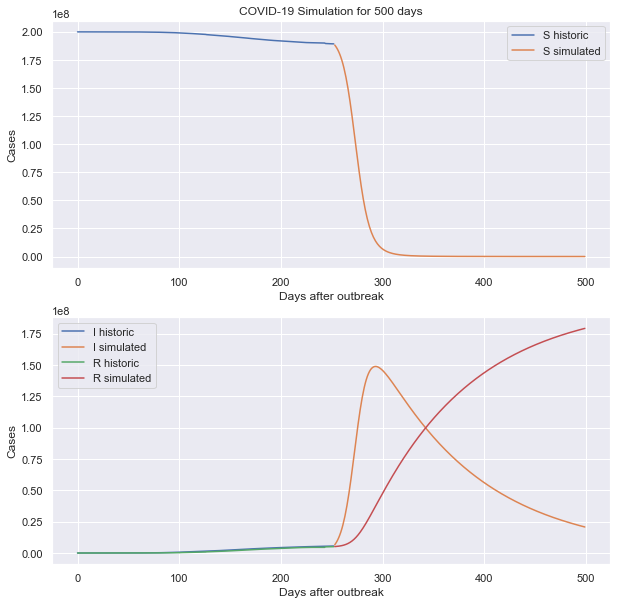

In [91]:
T=500   #number of sim (dt days)
t0=len(s_data) #the first day of simulation is the next day from last historic data


def beta(day):
    return A_beta*exp(b_beta*day)


data=[]

#Initial conditions

S=s_data[-1]
I=i_data[-1]
R=r_data[-1]

a=alfa
g= 0.01
t = 0
h = 1

while t < (T-t0):

    if I==0:
        break

    b = beta(t)

    dS=-b*S*I*dt/N
    dR=g*I*dt
    dI = -(dS+dR)

    S+=int(dS)*h
    R+=int(dR)*h
    I+=int(dI)*h
    data.append([S,I,R])
    t+= h

data = np.array(data)


days = [i for i in range(T)]

fig,axs=plt.subplots(2)
fig.set_size_inches(10,10, forward=True)

axs[0].plot(days[:t0],s_data,label='S historic')
axs[0].plot(days[t0:],data[:,0],label='S simulated')

axs[1].plot(days[:t0],i_data,label='I historic')
axs[1].plot(days[t0:],data[:,1],label='I simulated')

axs[1].plot(days[:t0],r_data,label='R historic')
axs[1].plot(days[t0:],data[:,2],label='R simulated')

axs[0].set_xlabel('Days after outbreak')
axs[1].set_xlabel('Days after outbreak')
axs[0].set_ylabel('Cases')
axs[1].set_ylabel('Cases')
axs[0].set_title(f'COVID-19 Simulation for {T} days')
axs[0].legend()
axs[1].legend()
plt.show();

## Plot simulation

In [1]:
days_historic = [i for i in range(len(s_data))]
days_sim = [i+t0 for i in range(T)]

fig,axs=plt.subplots(2)
fig.set_size_inches(10,10, forward=True)

axs[0].plot(days_historic,s_data,label='S historic')
axs[0].plot(days_sim,data[:,0],label='S simulated')

axs[1].plot(days_historic,i_data,label='I historic')
axs[1].plot(days_sim,data[:,1],label='I simulated')

axs[1].plot(days_historic,r_data,label='R historic')
axs[1].plot(days_sim,data[:,2],label='R simulated')

axs[1].plot(days_historic,d_data,label='D historic')
axs[1].plot(days_sim,data[:,3],label='D simulated')

axs[0].set_xlabel('Days after outbreak')
axs[1].set_xlabel('Days after outbreak')
axs[0].set_ylabel('Cases')
axs[1].set_ylabel('Cases')
axs[0].set_title(f'COVID-19 Simulation for {T} days')
axs[0].legend()
axs[1].legend()
plt.show();

NameError: name 's_data' is not defined